In [7]:
import sconce
print(f"Notebook run using pytorch-sconce {sconce.__version__}")

Notebook run using pytorch-sconce 1.2.5


In [8]:
from sconce.data_feeds import SingleClassImageFeed
from sconce.datasets import Subset
from torchvision import datasets, transforms

import numpy as np
import random

## Creating the Training and Validation Data Feeds

In [9]:
split_factor = 0.85
root = 'data/characters'
image_size = 64

def one_of_five(image_size):
    def fn(image_input):
        five_crops = transforms.FiveCrop(image_size)(image_input)
        return random.choice(five_crops)
    return fn
    
training_transform = transforms.Compose([
    transforms.Resize(int(image_size*1.5)),
    one_of_five(int(image_size) * 1.15),
    transforms.RandomAffine(degrees=(0,10), translate=(0.02, 0.02), scale=(1.0, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0], std=[1.0])
])

validation_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0], std=[1.0])
])

base_feed = SingleClassImageFeed.from_image_folder(root=root, transform=training_transform)
training_feed, validation_feed = base_feed.split(split_factor,
        batch_size=60, num_workers=7, shuffle=True, validation_transform=validation_transform)

In [10]:
inputs, targets = training_feed.next()
inputs.shape, targets.shape

(torch.Size([60, 3, 64, 64]), torch.Size([60]))

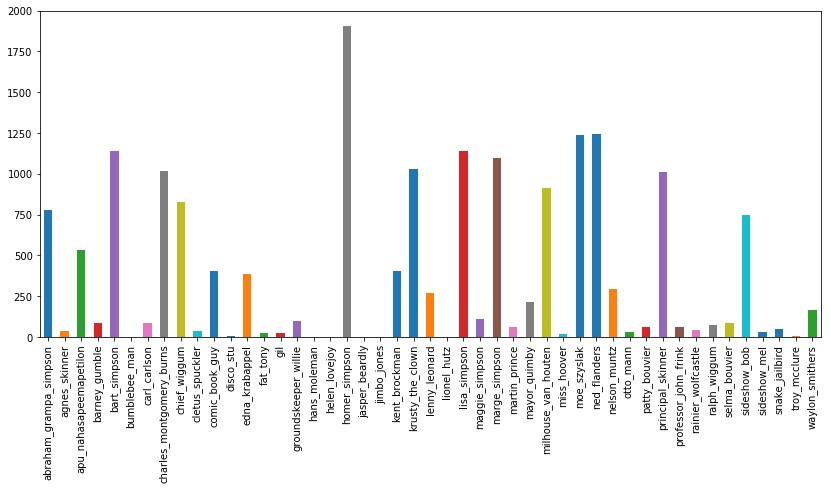

In [5]:
training_feed.plot_class_summary(figsize=(14,6))

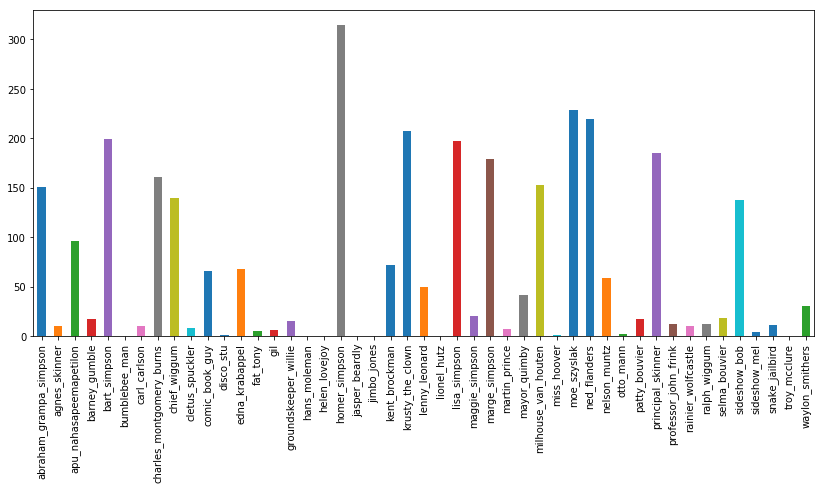

In [16]:
validation_feed.plot_class_summary(figsize=(14,6))

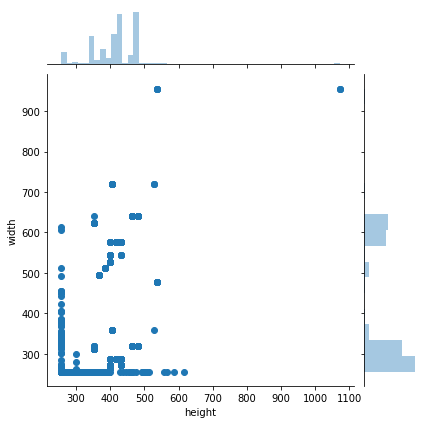

In [17]:
validation_feed.plot_image_size_summary();

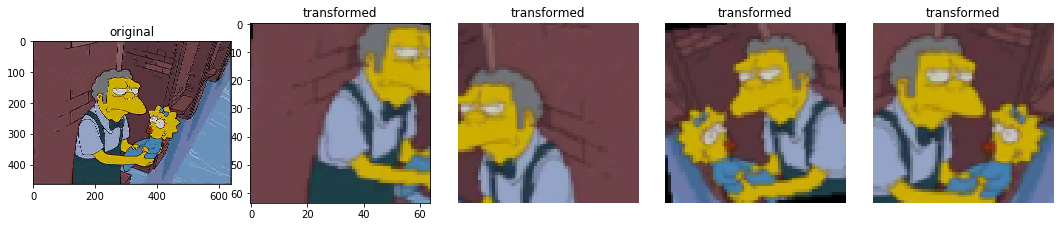

In [11]:
training_feed.plot_transforms(123)

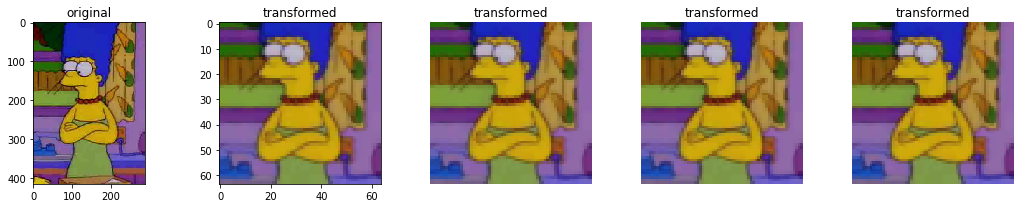

In [12]:
validation_feed.plot_transforms(126)

## Define the Model and construct the Trainer

In [13]:
from sconce.models import WideResnetImageClassifier

In [14]:
num_classes = len(training_feed.dataset.classes)
m = WideResnetImageClassifier(image_channels=3, depth=28, widening_factor=4, num_categories=num_classes)

In [15]:
from torch import optim

m.set_optimizer(optim.SGD, lr=0.1, momentum=0.9, weight_decay=5e-4)

In [16]:
import torch

if torch.cuda.is_available:
    m.cuda()
    training_feed.cuda()
    validation_feed.cuda()

In [17]:
from sconce.trainers import SingleClassImageClassifierTrainer

In [18]:
t = SingleClassImageClassifierTrainer(model=m, training_feed=training_feed, validation_feed=validation_feed)

## Survey the learning rate

119/119 [==============================] - 45s 380ms/step - loss: 3.3446


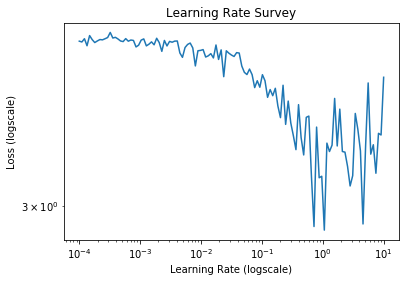

In [14]:
monitor = t.survey_learning_rate(num_epochs=0.4, min_learning_rate=1e-4, max_learning_rate=10)
monitor.dataframe_monitor.plot_learning_rate_survey()

## Train

In [19]:
from sconce.schedules import Triangle
m.set_schedule('learning_rate', Triangle(initial_value=1e-3, peak_value=1e0, peak_fraction=0.33))
m.set_schedule('momentum', Triangle(initial_value=0.98, peak_value=0.02, peak_fraction=0.33))
t.train(num_epochs=40)

11862/11862 [==============================] - 4767s 402ms/step - loss: 0.5871 - val_loss: 0.3174


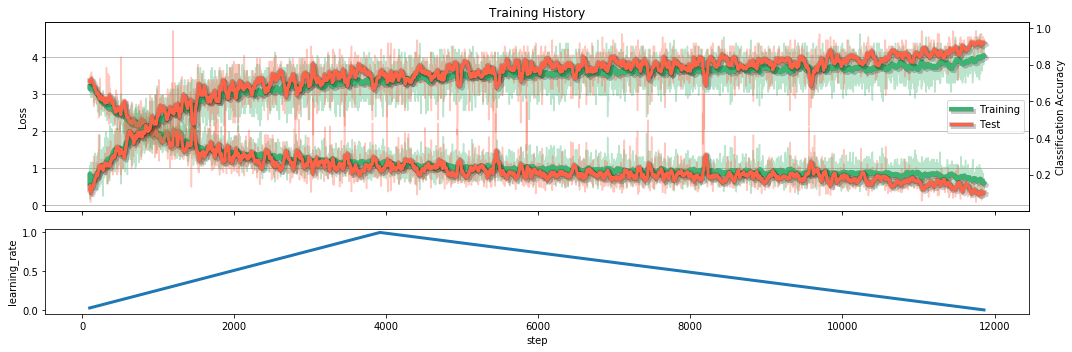

In [20]:
t.monitor.dataframe_monitor.plot(metrics=['loss', 'classification_accuracy']);

In [21]:
from sconce.schedules import Linear
m.set_schedule('learning_rate', Linear(initial_value=1e-3, final_value=0.0))
m.set_schedule('momentum', 0.98)
t.train(num_epochs=10)

2966/2966 [==============================] - 1192s 402ms/step - loss: 0.4346 - val_loss: 0.2119


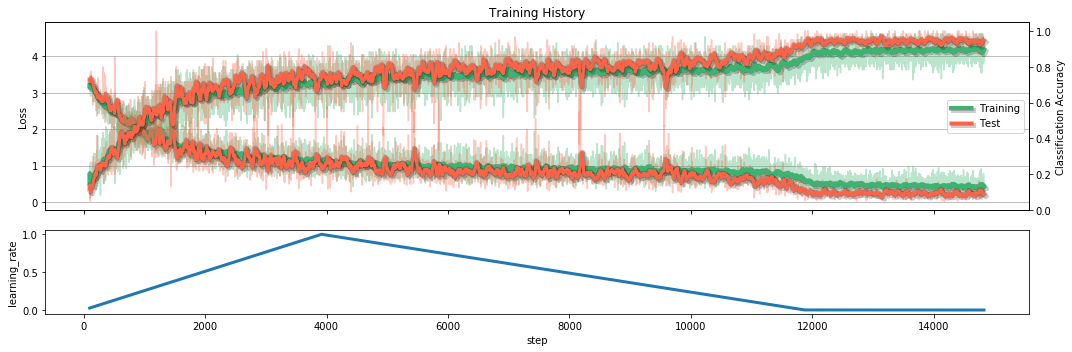

In [22]:
t.monitor.dataframe_monitor.plot(metrics=['loss', 'classification_accuracy']);

## Explore predictions of trained model

In [23]:
t.get_classification_accuracy()

0.9461783439490445

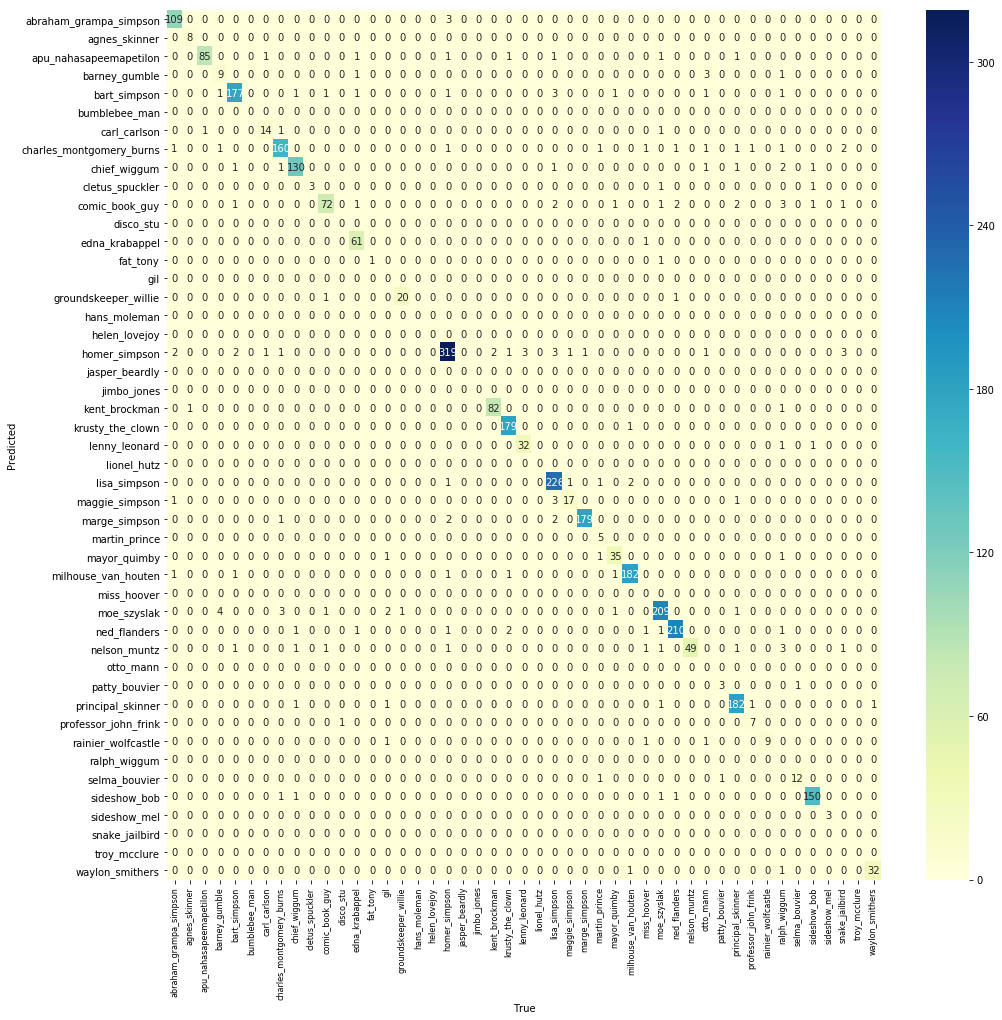

In [24]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(16, 16)) 
ax = t.plot_confusion_matrix(ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 8)
ax

Showing only the first 7 of 179 images


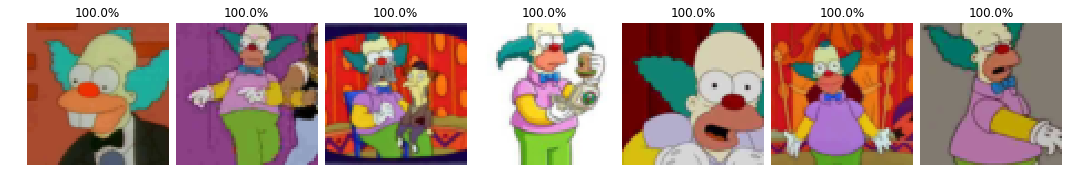

In [25]:
t.plot_samples(predicted_class='krusty_the_clown', true_class='krusty_the_clown',
               sort_by='falling predicted class score');

Showing only the first 7 of 12 images


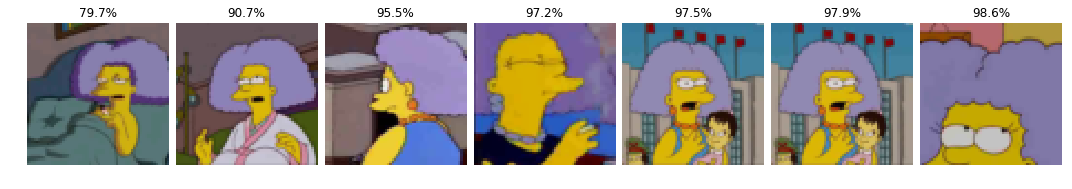

In [26]:
t.plot_samples(predicted_class='selma_bouvier', true_class='selma_bouvier');

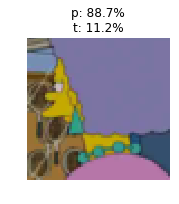

In [27]:
t.plot_samples(predicted_class='patty_bouvier', true_class='selma_bouvier');

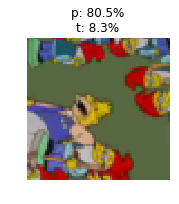

In [30]:
t.plot_samples(predicted_class='milhouse_van_houten', true_class='abraham_grampa_simpson');

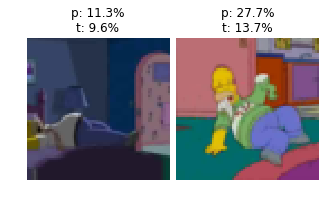

In [31]:
t.plot_samples(predicted_class='marge_simpson', true_class='homer_simpson');